In [1]:
%matplotlib inline

In this notebook, we demonstrate a basic example using the *lineal spring* method, as described in [Farhat et al. 1998]

The idea of the lineal spring method is to re-interpret the edges of a mesh as a structure of stiff beams. Each beam has a stiffness associated with it, which is related to its length and its orientation. We can assemble this information as a *stiffness matrix*,

$$
    \underline{\mathbf K}=\begin{bmatrix}
    \underline{\mathbf K_{11}} && \dots && \underline{\mathbf K_{1N}}\\
    \vdots && \ddots && \vdots\\
    \underline{\mathbf K_{N1}} && \dots && \underline{\mathbf K_{NN}}\\
    \end{bmatrix},
$$

where $N$ is the number of vertices in the mesh and each block $\underline{\mathbf K_{ij}}\not=\underline{\boldsymbol0}$ if and only if vertex $i$ is connected to vertex $j$. For a 2D problem, each $\underline{\mathbf K_{ij}}\in\mathbb R^{2\times2}$ and $\underline{\mathbf K}\in\mathbb R^{2N\times2N}$.

Suppose we apply a forcing, which acts on the vertices according to a forcing matrix

$$
    \underline{\mathbf f}
    =\begin{bmatrix}
        \mathbf f_1\\
        \vdots\\
        \mathbf f_N\\
    \end{bmatrix}
    \in\mathbb R^{N\times2}.$$
    
That is, vertex $i$ is forced according to a vector $\mathbf f_i$. Then we are able to compute the displacement of the vertices by solving the linear system

$$\underline{\mathbf K}\mathbf u=\mathbf f,$$

where $\mathbf u\in\mathbf R^{2N}$ and $\mathbf f\in\mathbf R^{2N}$ are "flattened" versions of the displacement and forcing vectors. By solving this equation, we see how the structure of beams responds to the forcing.


[Farhat et al. 1998] *Farhat, Degand, Koobus and Lesoinne, "Torsional springs for two-dimensional dynamic unstructured fluid meshes" (1998), Computer methods in applied mechanics and engineering, 163:231-245.*

In [2]:
from firedrake import *
from movement import *

In [3]:
from plotting import *
import numpy as np

Let's start with a uniform mesh of the unit square. It has four boundary segments, which are tagged with the integers 1, 2, 3 and 4. Note that segment 4 corresponds to the top boundary.

In [4]:
n = 10
mesh = UnitSquareMesh(n, n)
V = mesh.coordinates.function_space()

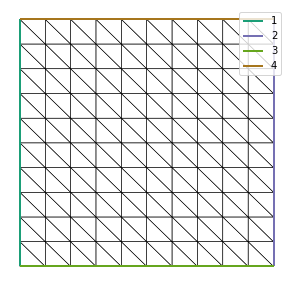

In [5]:
fig, axes, tp = plot_mesh(mesh)
axes.legend();

We are going to apply a time-dependent forcing to the top boundary and see how the mesh structure responds. Consider the forcing

$$\mathbf f(x,y,t)=\left[0, A\:\sin\left(\frac{2\pi t}T\right)\:\sin(\pi x)\right]$$

acting only in the vertical direction.

In [6]:
A = 0.5  # forcing amplitude
T = 1.0  # forcing period

In [7]:
def forcing(x, t):
    return A * np.sin(2 * pi * t / T) * np.sin(pi * x)

In [8]:
x = np.linspace(0, 1, n+1)
dt = 0.1
times = np.arange(0, 1.001, dt)
results = [forcing(x, t) for t in times]

In [9]:
fig, axes = plt.subplots()

def animate(c):
    axes.clear()
    axes.plot(x, c)
    axes.set_xlim([0, 1])
    axes.set_ylim([-A, A])

HTML(plot_video(fig, animate, results, dt))

To apply this forcing, we need to create a ``SpringMover`` instance and define an ``update_forcings`` function that applies ``forcing`` to the boundary nodes. The way that we get the right indices for the top boundary is using a ``DirichletBC`` object.

In [10]:
mover = SpringMover(mesh, method="lineal")
boundary_nodes = DirichletBC(V, 0, 4).nodes

In [11]:
def update_forcings(t):
    coords = mover.mesh.coordinates.dat.data
    for i in boundary_nodes:
        mover.f.dat.data[i, 1] = forcing(coords[i, 0], t)

We are now able to apply the mesh movement method. The forcings effectively enforce a Dirichlet boundary condition on the top boundary. On the other boundaries, we enforce that there is no movement using the ``fixed_boundaries`` keyword argument.

In [12]:
results = []
for t in times:
    mover.move(t, update_forcings=update_forcings, fixed_boundaries=[1, 2, 3])
    print(f"time = {t:.1f} seconds,   displacement = {np.linalg.norm(mover.displacement):.2f} metres")
    t += dt
    results.append(Mesh(mover.mesh.coordinates.copy(deepcopy=True)))

time = 0.0 seconds,   displacement = 0.00 metres
time = 0.1 seconds,   displacement = 0.40 metres
time = 0.2 seconds,   displacement = 0.67 metres
time = 0.3 seconds,   displacement = 0.70 metres
time = 0.4 seconds,   displacement = 0.42 metres
time = 0.5 seconds,   displacement = 0.00 metres
time = 0.6 seconds,   displacement = 0.40 metres
time = 0.7 seconds,   displacement = 0.66 metres
time = 0.8 seconds,   displacement = 0.67 metres
time = 0.9 seconds,   displacement = 0.41 metres
time = 1.0 seconds,   displacement = 0.00 metres


In [13]:
fig, axes = plt.subplots()

def animate(m):
    axes.clear()
    plot_mesh(m, fig=fig, axes=axes)

HTML(plot_video(fig, animate, results, dt))

Note that we can view the sparsity pattern of the stiffness matrix as follows.

Stiffness matrix shape: (242, 242)
Number of mesh vertices: 121


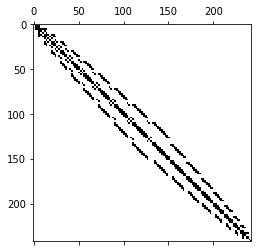

In [14]:
K = mover.stiffness_matrix
print(f"Stiffness matrix shape: {K.shape}")
print(f"Number of mesh vertices: {mesh.num_vertices()}")

fig, axes = plt.subplots()
axes.spy(K);